<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/01_Generalized_Linear_Models/02-01-07-04-glm-non-normal-fractional-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 7.4 Fractional Regression Models {.unnumbered}


Fractional regression models are essential for analyzing continuous proportion data — like rates, shares, or percentages — that fall between 0 and 1. Unlike OLS or logistic regression, they properly handle boundary values (0s and 1s) and heteroskedasticity. In this tutorial, you’ll learn the theory, build a model from scratch in R, and fit it the right way using `glm` — empowering you to model real-world fractional outcomes with confidence.

## Overview

**Fractional Regression Models**, also known as `fractional logit` or `proportion` regression models, are designed for dependent variables that are bounded between 0 and 1, such as proportions, fractions, or probabilities (e.g., market shares, test scores as percentages, or budget allocations). These models ensure predictions lie within the [0,1] interval and account for the bounded nature of the data.  Examples:

- Proportion of time spent on a task
- Fraction of budget allocated to R&D
- Market share of a product
- Student test scores (as %)
- Proportion of land under cultivation

Traditional linear regression is inappropriate here because:

- Predictions can fall outside [0,1]
- Heteroskedasticity: variance depends on mean
- Non-normal errors

Logistic regression (for binary outcomes) is also inappropriate — fractional data are **continuous proportions**, not binary.


Fractional regression typically uses a **quasi-likelihood approach** based on the **logit link** and **beta distribution variance function**.

Let $y_i \in [0,1]$ be the fractional response for observation $i$.

We model the **conditional mean** $\mu_i = E(y_i | x_i)$ via a link function $g(\cdot)$:

$$
g(\mu_i) = x_i^\top \beta
$$

Commonly, $g(\cdot)$ is the **logit link**:

$$
\text{logit}(\mu_i) = \ln\left(\frac{\mu_i}{1 - \mu_i}\right) = x_i^\top \beta
$$


Instead of assuming constant variance (like OLS), we assume the variance follows the **beta distribution** structure:

$$
\text{Var}(y_i) = \phi \cdot \mu_i (1 - \mu_i)
$$

where $\phi$ is a dispersion parameter (estimated from data).

> This is a **quasi-likelihood** model — we don’t assume a full probability distribution, only mean and variance functions.




### Key Properties

- Handles responses in [0,1]
- Uses link functions (logit, probit, cloglog, etc.)
- Accounts for heteroskedasticity via variance function
- Estimates interpretable as in logistic regression (log-odds)
- Can include 0s and 1s (unlike beta regression, which requires (0,1))

### Difference  Between **Beta Regression Models** and **Fractional Regression Models**

The difference between **Beta Regression Models** and **Fractional Regression Models** lies in their assumptions, modeling approach, and handling of the response variable, though both are used for dependent variables bounded between 0 and 1 (e.g., proportions or fractions). Below is a concise comparison:

 **Underlying Distribution**

- `Beta Regression`:
  - Assumes the response variable $y$ (where $0 < y < 1$ follows a **beta distribution**, parameterized by mean $\mu$ and precision $\phi$.
  - The beta distribution is flexible, accommodating various shapes (e.g., U-shaped, J-shaped) for proportions.
  - Typically excludes exact 0 or 1 values unless modified (e.g., using zero-inflated or one-inflated beta regression).
  - Variance is modeled as $\text{Var}(y) = \mu(1 - \mu) / (1 + \phi)$, where $\phi$ controls dispersion.

- `Fractional Regression`:
  - Does not assume a specific distributional form like the beta distribution.
  - Uses a **quasi-likelihood** approach, focusing on the mean and variance structure: \( E(y | \mathbf{x}) = \mu \) and \( \text{Var}(y) = \mu(1 - \mu) \).
  - Can handle exact 0 and 1 values naturally, as it does not require a strict distributional assumption.
  - Often employs a logistic link to ensure predictions lie in (0,1), but other link functions (e.g., probit) are possible.

 **Handling Boundary Values (0 and 1)**

- `Beta Regression`:
  - Standard beta regression assumes $0 < y < 1$, so exact 0 or 1 values require special handling (e.g., transformation or inflated models).
  - Packages like `betareg` in R offer extensions (e.g., `betareg(..., type = "BC")`) for zero- or one-inflated data.
  
-`Fractional Regression`:
  - Naturally accommodates $y \in [0,1]$, including boundary values, without requiring distributional adjustments.
  - Robust for datasets with many 0s or 1s (e.g., market shares where some observations are 0% or 100%).

**Estimation Approach**

- `Beta Regression`:
  - Uses **maximum likelihood estimation** (MLE) based on the beta distribution.
  - Estimates both regression coefficients ($\boldsymbol{\beta}$) for the mean and a precision parameter ($\phi$).
  - More computationally intensive due to the full distributional assumption.
  
-  `Fractional Regression`:
  - Uses **quasi-likelihood estimation**, which only requires specifying the mean ($\mu = g^{-1}(\mathbf{x}^\top \boldsymbol{\beta})$) and variance ($\mu(1 - \mu)$).
  - Simpler and more robust to misspecification of the data distribution.

**Model Flexibility**

- `Beta Regression`:
  - More flexible in modeling the shape of the distribution (via the precision parameter \( \phi \)).
  - Suitable when the data exhibit complex patterns (e.g., skewed or bimodal proportions).
  - Can model heteroscedasticity explicitly through a separate regression for \( \phi \).

- `Fractional Regression`:
  - Less flexible in terms of distributional shape, as it focuses on the mean-variance relationship.
  - Assumes a fixed variance function ($\mu(1 - \mu)$), which may not capture all data patterns.

**Applications**

- `Beta Regression`:
  - Ideal for continuous proportions with variability well-described by the beta distribution (e.g., test scores, chemical yields).
  - Preferred when modeling dispersion or when the data are strictly between 0 and 1.
  
- `Fractional Regression`
  - Suited for proportions that include 0 or 1 (e.g., market shares, budget allocations).
  - Used in econometrics and social sciences where boundary values are common and distributional assumptions are less critical.

## Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316572 sha256=82beee814b7f380eedddf6c09041289f53a85878966faaf97bf7b46845839f16
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  Fit Fractional Regression from Scratch in R (No Packages)

We’ll implement **Iteratively Reweighted Least Squares (IRLS)** to fit a fractional logit model.

###  Simulate Data


In [3]:
%%R
# Recreate data if needed
set.seed(123)
n <- 500
x1 <- rnorm(n)
x2 <- runif(n, -1, 1)
X_mat <- cbind(1, x1, x2)
beta_true <- c(-0.5, 1.2, -0.8)
eta <- X_mat %*% beta_true
mu <- 1 / (1 + exp(-eta))
phi <- 5
alpha <- mu * phi
beta_param <- (1 - mu) * phi
y <- rbeta(n, shape1 = alpha, shape2 = beta_param)
y[sample(1:n, 20)] <- 0
y[sample(1:n, 20)] <- 1
data_scratch <- data.frame(y = y, x1 = x1, x2 = x2)

data_scratch <- data.frame(y = y, x1 = x1, x2 = x2)
head(data_scratch)

          y          x1          x2
1 0.2813101 -0.56047565 -0.45275453
2 1.0000000 -0.23017749  0.18773387
3 0.9203128  1.55870831 -0.67963037
4 0.0000000  0.07050839  0.70686048
5 0.0000000  0.12928774  0.69547832
6 0.9733129  1.71506499 -0.04422637


### Implement IRLS Algorithm

In [5]:
%%R
fractional_logit_irls <- function(y, X, maxit = 100, tol = 1e-8) {

  n <- length(y)
  p <- ncol(X)

  # Ensure X is matrix
  X <- as.matrix(X)

  # Initialize coefficients
  beta <- rep(0, p)

  # Add small jitter to avoid 0/1 (for logit)
  y_adj <- ifelse(y == 0, 0.001, ifelse(y == 1, 0.999, y))

  for (iter in 1:maxit) {
    eta <- X %*% beta
    mu <- inv_logit(eta)

    # Variance function: mu*(1-mu)
    v <- mu * (1 - mu)
    weights <- 1 / v  # Diagonal of weight matrix

    # Derivative of mu w.r.t. eta
    dmu_deta <- dinv_logit(eta)

    # Working response (adjusted dependent variable)
    z <- eta + (y_adj - mu) / dmu_deta

    # Weight X by multiplying each row by its weight
    X_weighted <- sweep(X, MARGIN = 1, STATS = weights, FUN = "*")
    XtWX <- t(X) %*% X_weighted

    # Weight z
    z_weighted <- weights * z
    XtWz <- t(X) %*% z_weighted

    # Solve for new beta
    beta_new <- solve(XtWX, XtWz)

    # Check convergence
    if (sqrt(sum((beta_new - beta)^2)) < tol) {
      cat("Converged in", iter, "iterations.\n")
      beta <- beta_new
      break
    }

    beta <- beta_new
  }

  # Recompute final fit
  eta <- X %*% beta
  mu <- inv_logit(eta)

  # Estimate dispersion phi
  pearson_resid_sq <- (y - mu)^2 / (mu * (1 - mu))
  phi_hat <- sum(pearson_resid_sq) / (n - p)

  # Compute standard errors
  final_weights <- 1 / (mu * (1 - mu))
  X_weighted_final <- sweep(X, 1, final_weights, "*")
  XtWX_final <- t(X) %*% X_weighted_final
  cov_mat <- solve(XtWX_final) * phi_hat
  se <- sqrt(diag(cov_mat))

  # Inference
  z_scores <- beta / se
  p_values <- 2 * pnorm(-abs(z_scores))

  list(
    coefficients = beta,
    se = se,
    z_values = z_scores,
    p_values = p_values,
    fitted.values = mu,
    residuals = y - mu,
    phi = phi_hat,
    iterations = iter
  )
}

### Fit the Model

In [7]:
%%R
# Fit model
model_scratch <- fractional_logit_irls(data_scratch$y, X_mat)

# Display results
cat("=== Fractional Logit Model (From Scratch) ===\n")
print(data.frame(
  Coefficient = model_scratch$coefficients,
  Std_Error = model_scratch$se,
  Z_value = model_scratch$z_values,
  P_value = model_scratch$p_values
))

cat("\nEstimated dispersion (phi):", model_scratch$phi, "\n")

Converged in 20 iterations.
=== Fractional Logit Model (From Scratch) ===
   Coefficient   Std_Error   Z_value       P_value
    -0.3574694 0.009990005 -35.78271 2.051904e-280
x1   1.1424553 0.007825807 145.98562  0.000000e+00
x2  -0.5752209 0.017655561 -32.58015 7.836170e-233

Estimated dispersion (phi): 0.2973597 


### Validate Model (Basic Diagnostics)

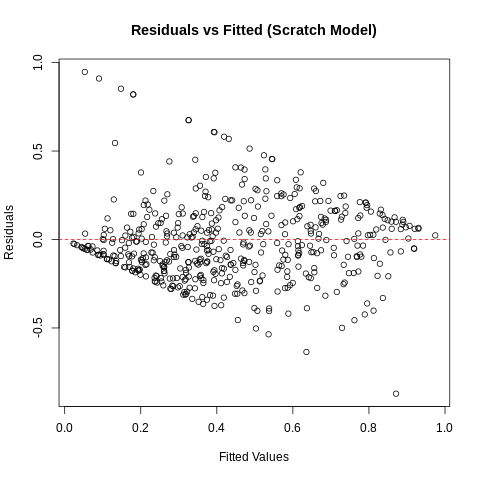

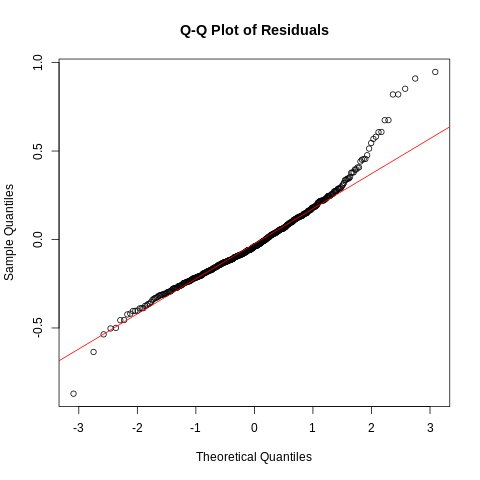

In [10]:
%%R
# Residuals vs Fitted
plot(model_scratch$fitted.values, model_scratch$residuals,
     xlab = "Fitted Values", ylab = "Residuals",
     main = "Residuals vs Fitted (Scratch Model)")
abline(h = 0, col = "red", lty = 2)

# Q-Q plot (approximate, since not normal)
qqnorm(model_scratch$residuals, main = "Q-Q Plot of Residuals")
qqline(model_scratch$residuals, col = "red")

## Fit Fractional Regression Using R Package (`betareg`)

Although `betareg` is designed for beta regression (strictly (0,1)), it can be adapted for fractional data with 0s and 1s using **zero/one inflated beta models** or by **adjusting the data slightly**.
Alternatively, we can use `glm` with `family = quasibinomial` — which is **exactly** the fractional logit model!

>  `glm(..., family = quasibinomial(link = "logit"))`


### Check and Install Required R Packages

In [12]:
%%R
packages <- c('tidyverse',
		 'performance',
	   'report',
		 'sjPlot',
		 'margins',
		 'marginaleffects',
		 'ggeffects',
		 'patchwork',
     'betareg',
    'lmtest'
	  	)

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [13]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages

Successfully loaded packages:
 [1] "package:lmtest"          "package:zoo"            
 [3] "package:betareg"         "package:patchwork"      
 [5] "package:ggeffects"       "package:marginaleffects"
 [7] "package:margins"         "package:sjPlot"         
 [9] "package:report"          "package:performance"    
[11] "package:lubridate"       "package:forcats"        
[13] "package:stringr"         "package:dplyr"          
[15] "package:purrr"           "package:readr"          
[17] "package:tidyr"           "package:tibble"         
[19] "package:ggplot2"         "package:tidyverse"      
[21] "package:tools"           "package:stats"          
[23] "package:graphics"        "package:grDevices"      
[25] "package:utils"           "package:datasets"       
[27] "package:methods"         "package:base"           


### Data

In this tutorial, we will use Prater's well-known gasoline yield data from 1956. The primary variable of interest is `yield`, which represents the proportion of crude oil converted to gasoline after distillation and fractionation. A beta regression model is particularly suitable for analyzing this variable. We also have two explanatory variables: `temp`, the temperature (measured in degrees Fahrenheit) at which all the gasoline has vaporized, and `batch`, a categorical variable denoting ten unique batches of conditions involved in the experiments based on various other factors.

Source: Prater NH (1956). “Estimate Gasoline Yields from Crudes.” Petroleum Refiner, 35(5), 236–238.


In [14]:
%%R
data("GasolineYield", package = "betareg")
glimpse(GasolineYield)

Rows: 32
Columns: 6
$ yield    <dbl> 0.122, 0.223, 0.347, 0.457, 0.080, 0.131, 0.266, 0.074, 0.182…
$ gravity  <dbl> 50.8, 50.8, 50.8, 50.8, 40.8, 40.8, 40.8, 40.0, 40.0, 40.0, 3…
$ pressure <dbl> 8.6, 8.6, 8.6, 8.6, 3.5, 3.5, 3.5, 6.1, 6.1, 6.1, 6.1, 6.1, 6…
$ temp10   <dbl> 190, 190, 190, 190, 210, 210, 210, 217, 217, 217, 220, 220, 2…
$ temp     <dbl> 205, 275, 345, 407, 218, 273, 347, 212, 272, 340, 235, 300, 3…
$ batch    <fct> 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7…


### Fit with `glm` (Quasibinomial)



In [16]:
%%R
# Fit fractional logit model
model_glm <- glm(yield ~ gravity + pressure + temp10 + temp,
                 data = GasolineYield,
                 family = quasibinomial(link = "logit"))

summary(model_glm)


Call:
glm(formula = yield ~ gravity + pressure + temp10 + temp, family = quasibinomial(link = "logit"), 
    data = GasolineYield)

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.7423659  0.8229247  -3.332 0.002506 ** 
gravity      0.0049254  0.0076986   0.640 0.527707    
pressure     0.0318262  0.0303296   1.049 0.303321    
temp10      -0.0108551  0.0024437  -4.442 0.000136 ***
temp         0.0105105  0.0005558  18.910  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasibinomial family taken to be 0.00464114)

    Null deviance: 2.34184  on 31  degrees of freedom
Residual deviance: 0.12672  on 27  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 5



`plot_model()` function of {sjPlot} package creates plots the estimates from logistic model:

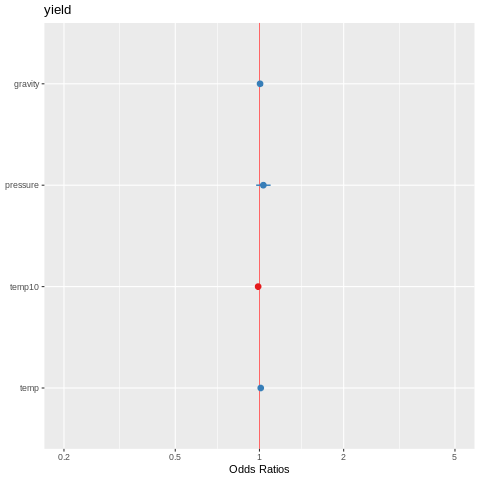

In [17]:
%%R
plot_model(model_glm, vline.color = "red")

In [18]:
%%R
performance::performance(model_glm)

# Indices of model performance

RMSE  | Sigma | Log_loss |   PCP
--------------------------------
0.024 | 0.068 |    0.032 | 0.030


### Marginal Effect

To calculate marginal effects and adjusted predictions, the `predict_response()` function of {ggeffects} package is used. This function can return three types of predictions, namely, conditional effects, marginal effects or marginal means, and average marginal effects or counterfactual predictions. You can set the type of prediction you want by using the `margin` argument.

  smooth plots.



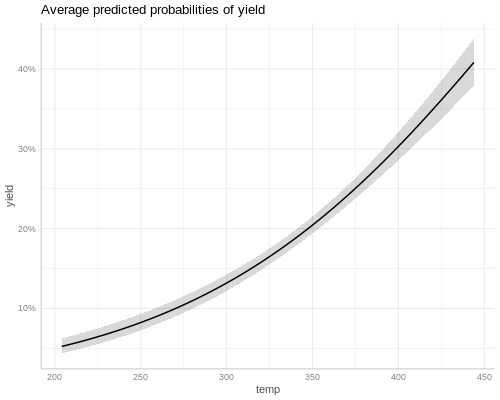

In [20]:
%%R -w 500 -h 400 -u px
effect.temp<-ggeffects::predict_response(model_glm, "temp", margin = "empirical")
plot(effect.temp)

### Compare with Scratch Model

In [21]:
%%R
# Extract coefficients
coef_glm <- coef(model_glm)
se_glm <- sqrt(diag(vcov(model_glm)))

# Compare with our scratch model (on same data? Not directly — different data)
# But you can run scratch model on GasolineYield too:

X_glm <- model.matrix(yield ~ gravity + pressure + temp10 + temp, data = GasolineYield)
y_glm <- GasolineYield$yield

model_compare <- fractional_logit_irls(y_glm, X_glm)

cat("=== Comparison: glm vs Scratch ===\n")
print(cbind(
  glm_coef = coef_glm,
  scratch_coef = model_compare$coefficients,
  diff = coef_glm - model_compare$coefficients
))

Converged in 15 iterations.
=== Comparison: glm vs Scratch ===
                glm_coef                          
(Intercept) -2.742365916 -2.650110240 -0.092255675
gravity      0.004925439 -0.004898497  0.009823936
pressure     0.031826230  0.065387148 -0.033560918
temp10      -0.010855131 -0.012541035  0.001685903
temp         0.010510529  0.012153076 -0.001642547


## Predictions and Interpretation

In [22]:
%%R
# Predict on new data
new_data <- data.frame(
  gravity = 40,
  pressure = 10,
  temp10 = 250,
  temp = 500
)

# Predicted proportion
pred_logit <- predict(model_glm, newdata = new_data, type = "link")
pred_prob <- predict(model_glm, newdata = new_data, type = "response")

cat("Predicted log-odds:", pred_logit, "\n")
cat("Predicted proportion:", pred_prob, "\n")

# Interpret coefficients: one-unit increase in temp → multiplicative change in odds
exp(coef(model_glm)["temp"])  # Odds multiplier per unit temp

Predicted log-odds: 0.3143955 
Predicted proportion: 0.5779578 
    temp 
1.010566 


## Summary and Conclusion

This tutorial taught you how to model proportion data (bounded between 0 and 1) using fractional regression in R — both from scratch and with built-in tools. You implemented a custom IRLS algorithm for fractional logit models, overcoming matrix dimension errors with `sweep()`, and compared it to the standard `glm(..., family = quasibinomial)` approach, which is recommended for real-world use. You now understand when to use fractional regression (instead of OLS or logistic), how to interpret coefficients as log-odds, and how to handle 0s/1s — equipping you to confidently analyze rates, shares, and percentages across economics, ecology, education, and beyond.



##  Resources

1.  Papke, L. E., & Wooldridge, J. M. (1996). Econometric methods for fractional response variables with an application to 401(k) plan participation rates. *Journal of Applied Econometrics*, 11(6), 619–632.

2. Ferrari, S., & Cribari-Neto, F. (2004). Beta regression for modelling rates and proportions. *Journal of Applied Statistics*, 31(7), 799–815.